# Modeling Experimental Playground

Try out multiple types of models and then select the most promising one for hyperparameter tuning.

In [2]:
import pickle
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import string
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline 

from imblearn.over_sampling import RandomOverSampler
import imblearn.pipeline as imblearnpipeline

import pandas as pd
import numpy as np
from PIL import Image
from os import path
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns


In [3]:
jun_2020_tweets = pd.read_csv('../data/us_only_external_data_tweets_TOOL_labeled.csv')
jan_2021_tweets_qh = pd.read_csv('../data/jan_2021_queried_tweets_HUMAN_labeled.csv')
jan_2021_tweets_q = pd.read_csv('../data/jan_2021_queried_tweets_TOOL_labeled.csv')
jan_2021_tweets_s = pd.read_csv('../data/jan_2021_streaming_tweets_TOOL_labeled.csv')

tweets_df = jun_2020_tweets.append(jan_2021_tweets_qh)
tweets_df.append(jan_2021_tweets_q)
tweets_df.append(jan_2021_tweets_s)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 38392 entries, 0 to 347
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        38392 non-null  int64  
 1   Unnamed: 0.1      38044 non-null  float64
 2   Unnamed: 0.1.1    38044 non-null  float64
 3   content           38392 non-null  object 
 4   user_loc          38392 non-null  object 
 5   user_screen_name  38392 non-null  object 
 6   retweet_count     38392 non-null  int64  
 7   fav_count         38392 non-null  int64  
 8   created_at        38392 non-null  object 
 9   char_count        38392 non-null  int64  
 10  sentiment_method  38392 non-null  object 
 11  sentiment         38392 non-null  object 
 12  _id               348 non-null    object 
 13  id_str            348 non-null    float64
dtypes: float64(3), int64(4), object(7)
memory usage: 4.4+ MB


(38392, 14)

In [5]:
tweets_df = pd.read_csv('../data/vetted_usa_tweets.csv')
tweets_df.info()
tweets_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30599 entries, 0 to 30598
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        30599 non-null  int64 
 1   Unnamed: 0.1      30599 non-null  int64 
 2   content           30599 non-null  object
 3   user_loc          30599 non-null  object
 4   user_screen_name  30599 non-null  object
 5   retweet_count     30599 non-null  int64 
 6   fav_count         30599 non-null  int64 
 7   created_at        30599 non-null  object
 8   char_count        30599 non-null  int64 
 9   sentiment_method  30599 non-null  object
 10  sentiment         30599 non-null  object
 11  loc_state         30599 non-null  object
 12  loc_state_vetted  30599 non-null  object
 13  region            30599 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.3+ MB


(30599, 14)

In [20]:
playground_tweet_tokenizer = TweetTokenizer(preserve_case=True, strip_handles=True, reduce_len=True)
playground_lemmatizer = WordNetLemmatizer()

def playground_tokenize_lemmatize_tweet(tweet):
    ''' 
    Tokenize then Lemmatize the given tweet 
    '''
    tokens = playground_tweet_tokenizer.tokenize(tweet)
    lemmatized_tokens = [playground_lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

def calc_and_display_performance_metric(classifer, Xtest, ytest, Xtrain, ytrain, classifier_predictions, class_label_names):
    '''
    Calcuate and display peformance metrics for a classifier
    '''
    # Metrics - on how well the classifer performed on test data AND getting metrics on training data to check for model overfitting.
    train_predictions = classifer.predict(Xtrain)
    show_peformance_metrics(ytrain, train_predictions, Xtest, ytest, classifier_predictions, class_label_names)
    # Confusion Matrix
    plot_pretty_cf(classifer, Xtest, ytest)

def show_peformance_metrics(y_train, y_train_pred, X_test, y_test, y_pred, names):
    ''' 
    Print out peformance metrics
    '''
    train_acc_core = accuracy_score(y_train, y_train_pred)
    test_acc_score = accuracy_score(y_test, y_pred)
    train_wf1_score = f1_score(y_train, y_train_pred, average='weighted')
    test_wf1_score = f1_score(y_test, y_pred, average='weighted')
    print('--------------------------------------------------------------------------')
    print('Training Accuracy:{:.4}\t\t Testing Accuracy: {:.4}'.format(train_acc_core, test_acc_score))
    print('Training Weighted F1:{:.4}\t\t Testing Weighted F1: {:.4}'.format(train_wf1_score, test_wf1_score))
    print('--------------------------------------------------------------------------')
    print(classification_report(y_test, y_pred, target_names=names))
    print('--------------------------------------------------------------------------')

def plot_pretty_cf(predictor, Xtest, ytest, cmap='Blues', normalize=None, title=None):
    ''' Plot a pretty confusion matrix '''
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_confusion_matrix(predictor, Xtest, ytest, cmap=cmap, normalize=normalize, ax=ax)
    ax.set_title(title, size='large')
    ax.set_xlabel('Predicted Label', size='medium')
    ax.set_ylabel('True Label', size='medium')
    plt.show()

In [11]:
tweets_df = tweets_df[['content', 'sentiment']]
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30599 entries, 0 to 30598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    30599 non-null  object
 1   sentiment  30599 non-null  object
dtypes: object(2)
memory usage: 478.2+ KB


In [12]:
tweets_df['sentiment'].value_counts()
# We have class imbalance here with many more positive tweets

positive    22618
neutral      4708
negative     3273
Name: sentiment, dtype: int64

## Modeling Exeperimentation Steps:

* Create TRAIN and TEST data sets

* Create a Pipeline to try out different classifiers
    * Apply light text processing and vectorize TRAIN data using TF-IDF 
    * Use the chosen classifier

* Create predictions for TEST set

* Examine performance metrics: Weighted F1 Scores
    * Compare the performance metricx for TRAIN and TEST  (If model does __much__ better on TRAIN than on TEST set, then we’re likely overfitting)

* Choose the most promosing classifer to move forward with hyperparameter tuning

In [13]:
# Get TRAIN and TEST data and target and prep for processing steps

three_label_names = ['Negative', 'Neutral', 'Positive']
playground_X = tweets_df['content']
playground_y = tweets_df['sentiment']
playground_X_train, playground_X_test, playground_y_train, playground_y_test = train_test_split(playground_X, playground_y, test_size=0.3, random_state=42)


In [14]:
# Text Processing - Vectorize the Tweets using - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.
# Use custom function as tokenzier - uses TweetTokenier and NLTK Wordnet Lemmatizier on the resulting tokens
# Use english stopwords. Not removing/stripping punctuation as it may be useful for sentiment classifification

playground_vectorizer = TfidfVectorizer(tokenizer=playground_tokenize_lemmatize_tweet,
                             stop_words=stopwords.words('english'),
                             decode_error='ignore')

--------------------------------------------------------------------------
Training Accuracy:1.0		 Testing Accuracy: 0.8385
Training Weighted F1:1.0		 Testing Weighted F1: 0.81
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.98      0.25      0.40       953
     Neutral       0.91      0.50      0.65      1420
    Positive       0.83      0.99      0.90      6807

    accuracy                           0.84      9180
   macro avg       0.90      0.58      0.65      9180
weighted avg       0.86      0.84      0.81      9180

--------------------------------------------------------------------------


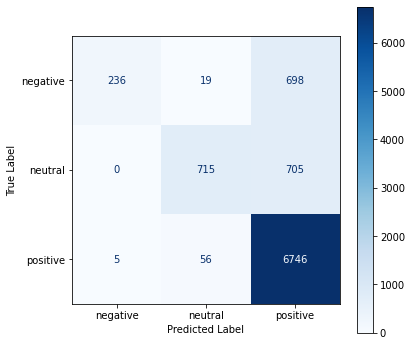

In [21]:
#  RandomForest
rf_clf = Pipeline([('tfidf', playground_vectorizer),
                    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
                    ])

rf_clf.fit(playground_X_train, playground_y_train)

rf_predictions = rf_clf.predict(playground_X_test)

calc_and_display_performance_metric(classifer=rf_clf, 
                                    Xtest=playground_X_test, 
                                    ytest=playground_y_test,
                                    Xtrain=playground_X_train,
                                    ytrain=playground_y_train,
                                    classifier_predictions=rf_predictions,
                                    class_label_names=three_label_names)

Weighted F1 score for Random Forest was lack-luster. The F1 scores for Negative and Neutral classes were both very poor. Let's consider other model types.

--------------------------------------------------------------------------
Training Accuracy:0.9682		 Testing Accuracy: 0.9038
Training Weighted F1:0.9684		 Testing Weighted F1: 0.9031
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.77      0.75      0.76       953
     Neutral       0.83      0.79      0.81      1420
    Positive       0.94      0.95      0.94      6807

    accuracy                           0.90      9180
   macro avg       0.84      0.83      0.84      9180
weighted avg       0.90      0.90      0.90      9180

--------------------------------------------------------------------------


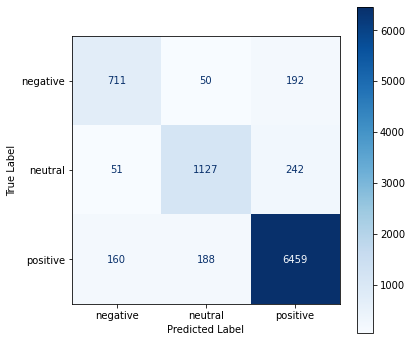

In [22]:
# SGDClassifier: Linear classifiers (SVM, logistic regression, etc.) with SGD training.
# The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).
# 
# loss set equal to hinge will yield behaviour such as that of a SVC with a linear kernel
# penalty defaults to ‘l2’ which is the standard regularizer for linear SVM models.
# 

sgd_clf = Pipeline([('tfidf', playground_vectorizer),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=2000, class_weight='balanced'))
                    ])
sgd_clf.fit(playground_X_train, playground_y_train)
sgd_predictions = sgd_clf.predict(playground_X_test)

calc_and_display_performance_metric(classifer=sgd_clf, 
                                    Xtest=playground_X_test, 
                                    ytest=playground_y_test,
                                    Xtrain=playground_X_train,
                                    ytrain=playground_y_train,
                                    classifier_predictions=sgd_predictions,
                                    class_label_names=three_label_names)


Weighted F1 score for SGDClassifier was better but the F1 scores for Negative and Neutral classes were both poor. Let's try out LinearSVC.

--------------------------------------------------------------------------
Training Accuracy:0.9968		 Testing Accuracy: 0.9203
Training Weighted F1:0.9968		 Testing Weighted F1: 0.9189
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.83      0.76      0.80       953
     Neutral       0.88      0.80      0.84      1420
    Positive       0.94      0.97      0.95      6807

    accuracy                           0.92      9180
   macro avg       0.88      0.84      0.86      9180
weighted avg       0.92      0.92      0.92      9180

--------------------------------------------------------------------------


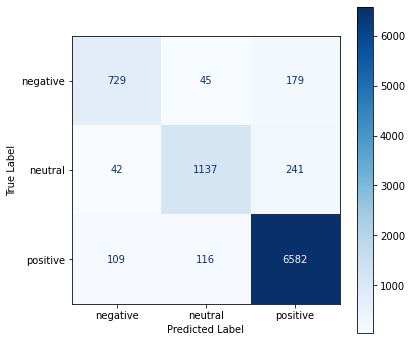

In [25]:
# Linear SVC with no hyperparameter tuning
not_tuned_lsvc_clf = Pipeline([('tfidf', playground_vectorizer),
                               ('clf', LinearSVC(class_weight='balanced', max_iter=2000))
                               ])

not_tuned_lsvc_clf.fit(playground_X_train, playground_y_train)
not_tuned_lsvc_predictions = not_tuned_lsvc_clf.predict(playground_X_test)

calc_and_display_performance_metric(classifer=not_tuned_lsvc_clf, 
                                    Xtest=playground_X_test, 
                                    ytest=playground_y_test,
                                    Xtrain=playground_X_train,
                                    ytrain=playground_y_train,
                                    classifier_predictions=not_tuned_lsvc_predictions,
                                    class_label_names=three_label_names)

Linear SVC is promising! Let's move forward with this one. See the modeling.ipynb notebook for hyperparameter tuning and final model performance.